# Unsupervised Algorithms in Machine Learning Final Project

## Martin

### Introduction

FOr the Unsuperivised Learning Final Project, we will be using the "Unsupervised Learning on Country Data" on Kaggle to use various clustering techniques in order to create models for HELP International. HELP assists with distributing amenities and relief to impoverished countries that face natural disasters and various calamities, as well as working to fight poverty in those nations to prevent the need for future aid.

The goal is to apply unsupervised learning techniques to cluster countries based on the given socio-economic and health factors. This can help in identifying similar countries and potentially guide policy-making decisions that could lead to a more efficient dispersal of aid by using similar policies for similarly impoverished countries.

### Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

### Loading and Checking Data

The dataset was collected from publicly available sources and compiled by the dataset author. It consists of country-level data, which includes factors such as GDP per capita, child mortality rate, exports, imports, and life expectancy, among others.

First, we'll be loading the data and making sure there are no missing values as these would impact any analyis we could do and throw our model off while it is learning.

In [2]:
# Set the file path
file_path = r'C:\Users\marti\Downloads\archive (1)'

# Load the dataset
countries_df = pd.read_csv(os.path.join(file_path, 'Country-data.csv'))

# Display the first few rows of the dataset
countries_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# Display basic statistics of the dataset
countries_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [4]:
# Check for missing values
missing_values = countries_df.isnull().sum()
print(f"Missing values:\n{missing_values}")

Missing values:
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


As we have no missing values, we are free to move on to a deeper inspection of the data

### Exploratory Data Analysis

#### Initial Data Inspection

We begin by loading the dataset and inspecting the first few rows to understand its structure. Basic statistics are generated to get an overview of the data distribution, including measures such as mean, median, and standard deviation.

### Visualization of Data Distribution

For each feature in the dataset, we use various visualizations such as histograms and box plots to describe the data distribution. This helps in understanding the spread and central tendency of the data, as well as identifying any potential outliers.

We'll start off with some histograms for each feature.

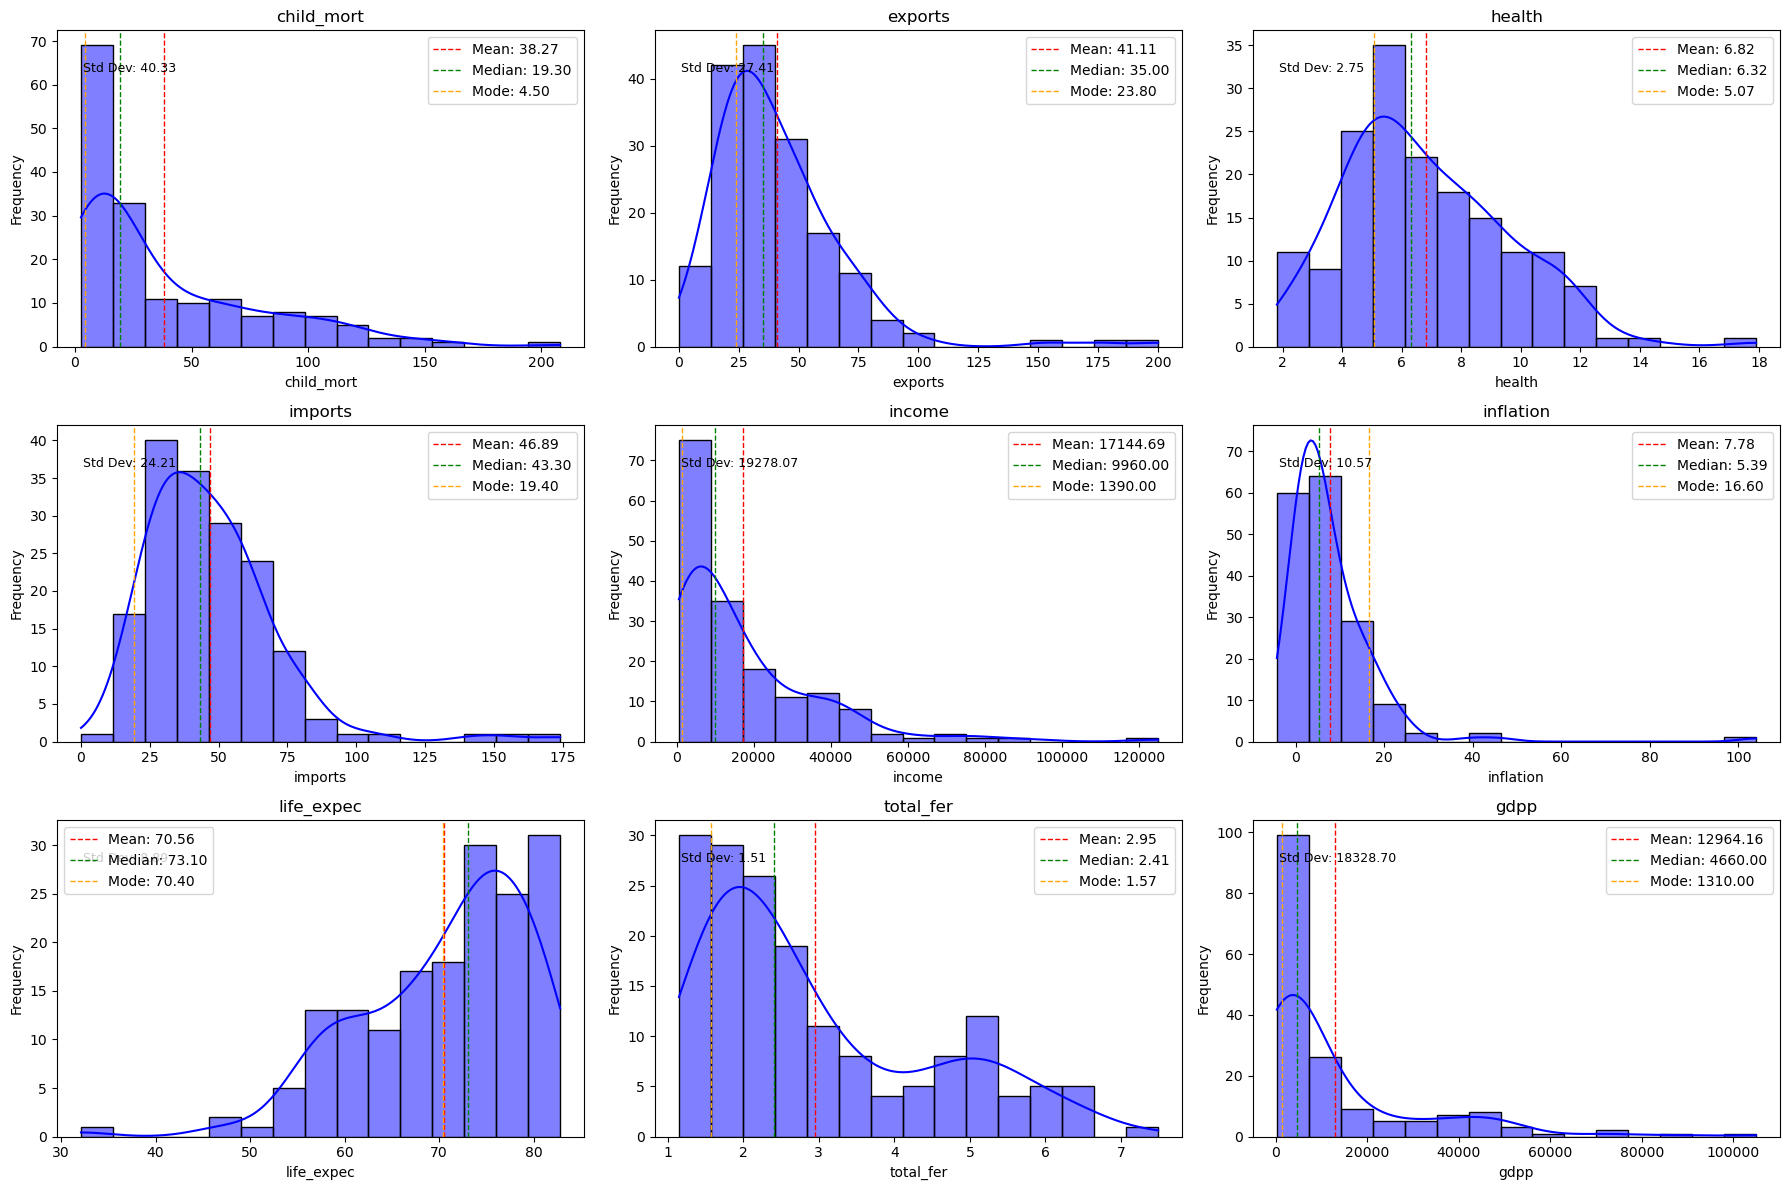

In [5]:
# Visualize the distribution of each feature
num_columns = 3 
numeric_columns = countries_df.select_dtypes(include=np.number).columns
num_plots = num_plots = len(numeric_columns)
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 4))
axes = axes.flatten()

# Iterate through each column and plot on the corresponding subplot
for i, column in enumerate(numeric_columns):
    # Plot the histogram
    sns.histplot(countries_df[column], bins=15, kde=True, color='blue', ax=axes[i])

    # Calculate statistics
    mean = countries_df[column].mean()
    median = countries_df[column].median()
    mode = countries_df[column].mode()[0]  # Mode might have multiple values; take the first one
    std_dev = countries_df[column].std()

    # Plot mean, median, and mode
    axes[i].axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
    axes[i].axvline(median, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
    axes[i].axvline(mode, color='orange', linestyle='dashed', linewidth=1, label=f'Mode: {mode:.2f}')

    # Set title and labels
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

    # Display standard deviation
    axes[i].text(0.05, 0.9, f'Std Dev: {std_dev:.2f}', transform=axes[i].transAxes, fontsize=9, verticalalignment='top')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Now that we have a decent understanding of the mathematics of the data lets see the numeric data as it relates to each other.

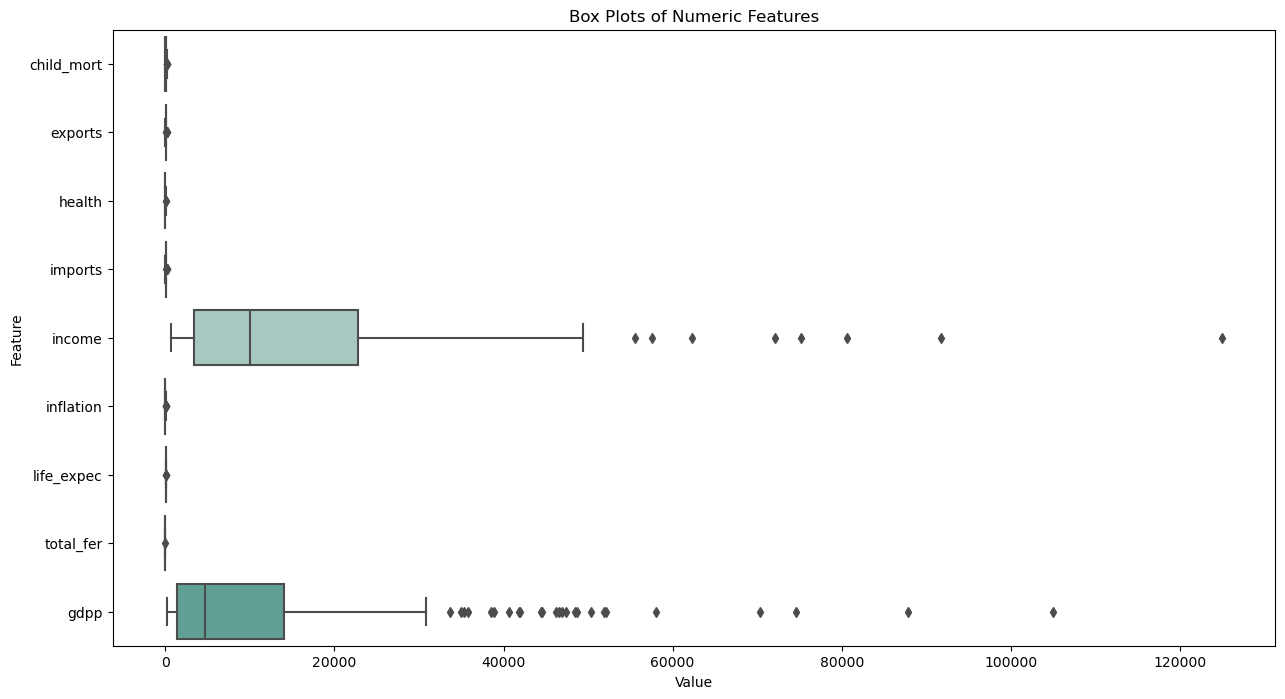

In [6]:
# Select only numeric columns
numeric_columns = countries_df.select_dtypes(include=np.number).columns

# Create a figure for the box plots
plt.figure(figsize=(15, 8))

# Plot all box plots in one graphic
sns.boxplot(data=countries_df[numeric_columns], orient='h', palette='light:#5A9')

# Set title and labels
plt.title('Box Plots of Numeric Features')
plt.xlabel('Value')
plt.ylabel('Feature')

# Display the plot
plt.show()

The results are expected, as GDP and Income as given in raw dollar amounts and are thus larger. We can make this comparison better by taking the two values and giving them as a figure of thousands (1,000s) of dollars by divding the values by 1000. 

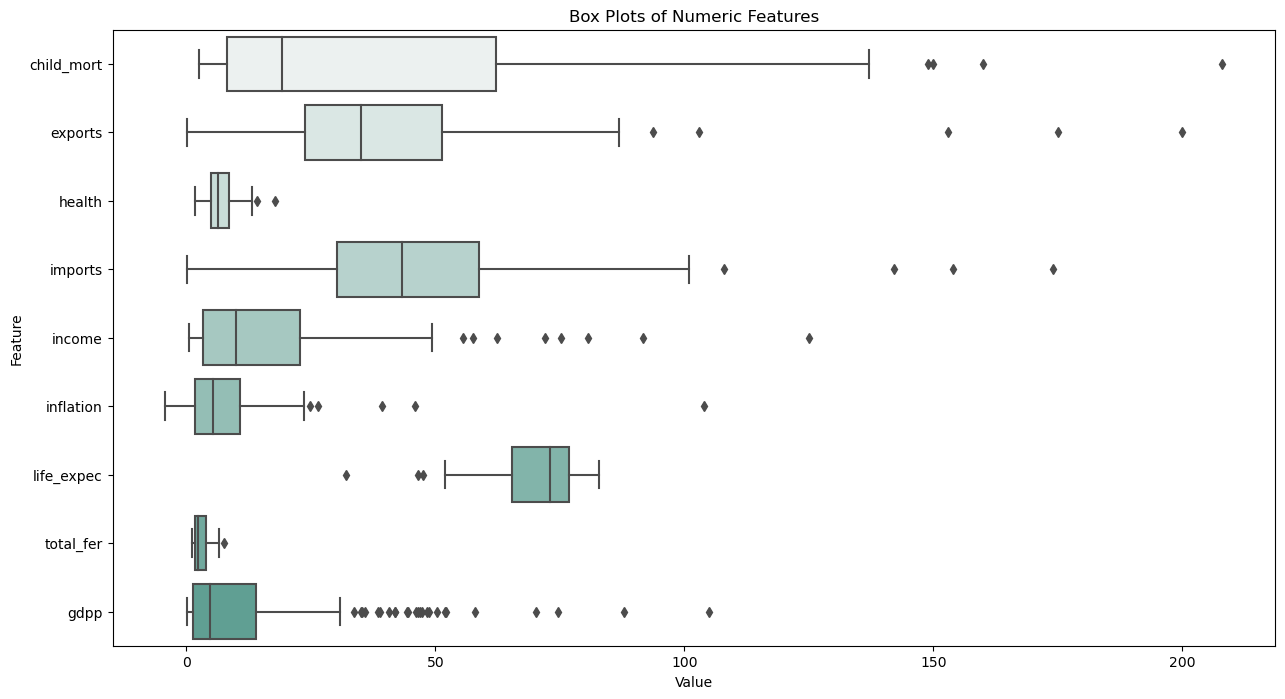

In [7]:
# Divide 'income' and 'gdpp' by 1000
countries_df['income'] = countries_df['income'] / 1000
countries_df['gdpp'] = countries_df['gdpp'] / 1000

# Select only numeric columns
numeric_columns = countries_df.select_dtypes(include=np.number).columns

# Create a figure for the box plots
plt.figure(figsize=(15, 8))

# Plot all box plots in one graphic
sns.boxplot(data=countries_df[numeric_columns], orient='h', palette='light:#5A9')

# Set title and labels
plt.title('Box Plots of Numeric Features')
plt.xlabel('Value')
plt.ylabel('Feature')

# Display the plot
plt.show()

Many of the features do indeed have rather large outliers but I do believe they can be helpful as we are attemtping to group the countries by need. These outliers may lead to differences in how the policies can apply to various edge cases.

#### Correlation Analysis

We perform a correlation analysis to determine the relationships between different features. The correlation matrix is visualized using a heatmap, where we can have the highly correlated factors highlighted for quick reference. 

This analysis helps in understanding which features might be more related and could influence clustering results.

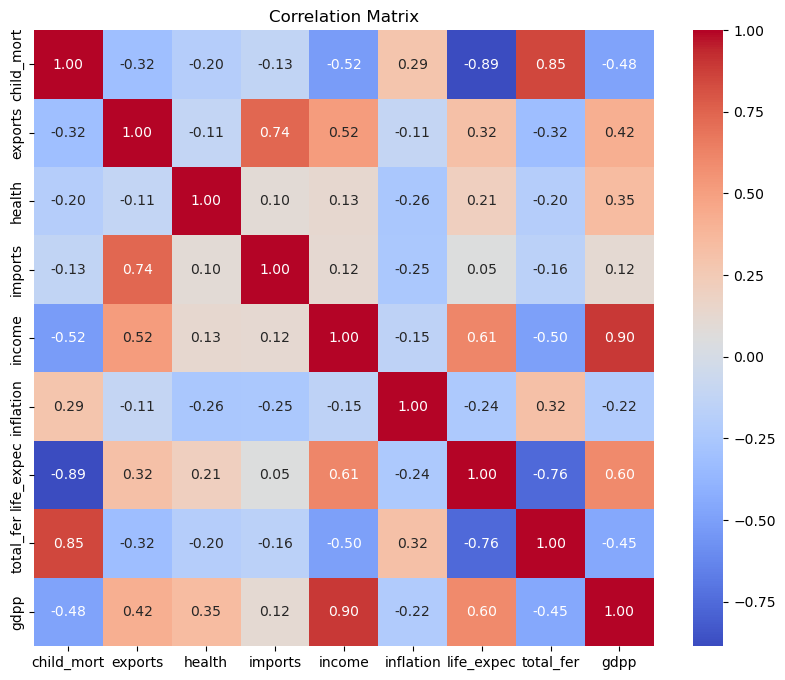

In [8]:
# Drop the 'country' column for correlation analysis
numeric_data = countries_df.drop(columns=['country'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In the heatmap above, we can see quite a few strong correlations:

-Income and GDPP or Gross Domestic Product per Capita

-Income (and GDPP) and Life Expectancy

-Income and Exports

-Exports and Imports

-Total Fertility and Child Mortality

As a preliminary supposition, I would argue that Income/Life Expectancy and Total Fertility/Child Mortality will be some of the correlations most impactful to this clustering.

### Unsupervised Learning Models

#### Model Selection

In this project, we will explore two unsupervised learning models, with a primary focus on clustering:

**Principal Component Analysis (PCA)**: We use PCA for dimensionality reduction to help visualize the data in two dimensions and understand the inherent structure of all of the features.

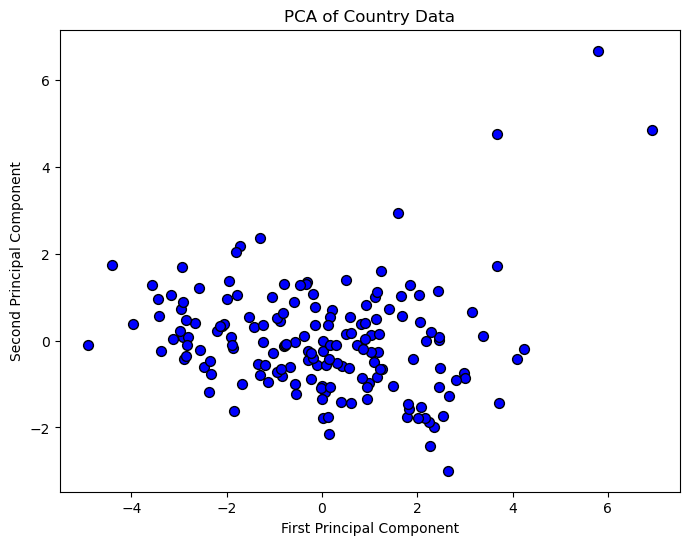

In [9]:
# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(countries_df.drop('country', axis=1))

# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c='blue', edgecolor='k', s=50)
plt.title('PCA of Country Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

**K-Means Clustering**: K-Means is applied to the dataset, and we experiment with different values of k to find the optimal number of clusters.

C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


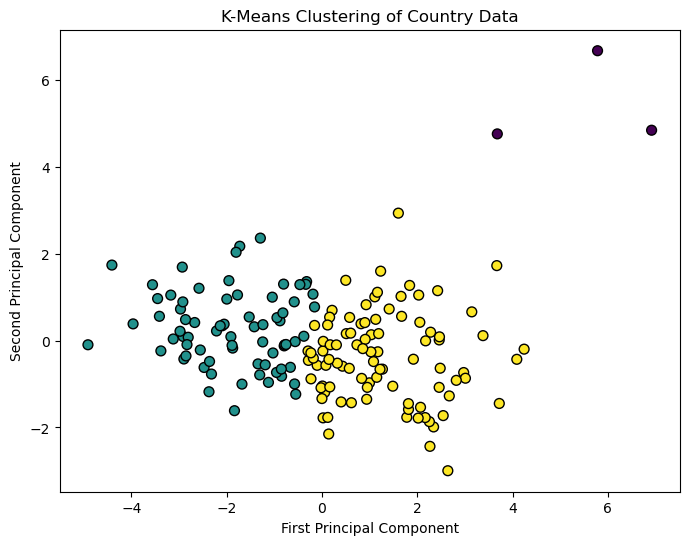

In [10]:
# Clustering using K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_data)
labels = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
plt.title('K-Means Clustering of Country Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

#### Hyperparameter Optimization

We perform hyperparameter optimization using GridSearchCV to find the best parameters for the K-Means algorithm. The silhouette score is used as a metric to evaluate the quality of clustering.

In [11]:
# Hyperparameter tuning with GridSearchCV
param_grid = {'n_clusters': range(2, 10)}
grid = GridSearchCV(KMeans(), param_grid, cv=5)
grid.fit(pca_data)

# Silhouette Score
silhouette_avg = silhouette_score(pca_data, labels)
print(f'Silhouette Score: {silhouette_avg}')

C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

Silhouette Score: 0.44162993549041984


#### Model Comparison and Discussion

Below the results from different models are compared, and the best-performing model is selected based on silhouette score and interpretability.

In [12]:
# Best parameters and silhouette score
print(f"Best parameters: {grid.best_params_}")
best_kmeans = grid.best_estimator_
best_labels = best_kmeans.labels_
best_silhouette = silhouette_score(pca_data, best_labels)
print(f'Best Silhouette Score: {best_silhouette}')

Best parameters: {'n_clusters': 9}
Best Silhouette Score: 0.34398984802472515


It would appear that the best parameter for us to choose is for a k-means cluster with the number of cluster steps being set to 9.

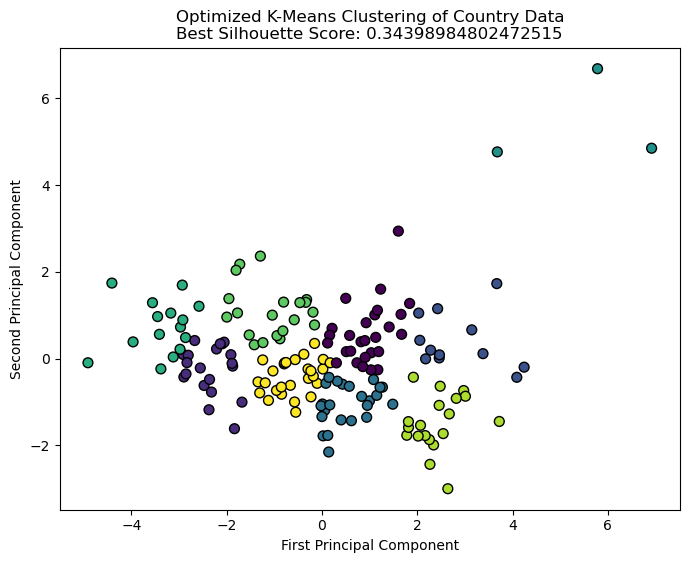

In [13]:
# Final clustering with the best model
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=best_labels, cmap='viridis', edgecolor='k', s=50)
plt.title(f'Optimized K-Means Clustering of Country Data\nBest Silhouette Score: {best_silhouette}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

### Conclusion

#### Analyzing the meaning of the clusters

In order to better interpret what the K-means clusters above mean for our data set, we can use a parrallel coordinates plot to view the centroids, essentially the mean values, of the data points in the clusters that we found.

An important note is that this will be after the PCA has reduced the features down to 2D components.

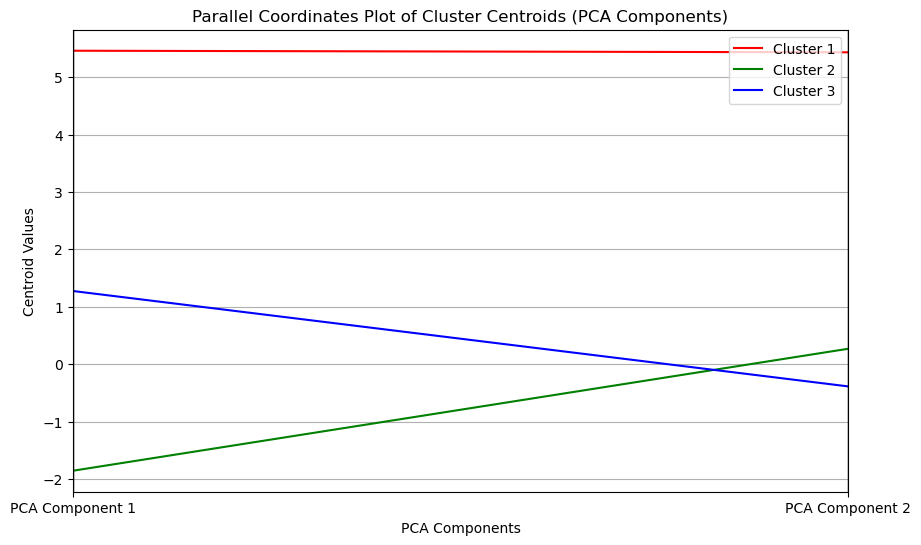

In [14]:
# Assume 'centroids' contains 2 PCA components
pca_columns = ['PCA Component 1', 'PCA Component 2']

# Extract centroids
centroids = kmeans.cluster_centers_

# Create a DataFrame with the PCA components
centroids_df = pd.DataFrame(centroids, columns=pca_columns)
centroids_df['Cluster'] = ['Cluster 1', 'Cluster 2', 'Cluster 3']

# Plot the parallel coordinates
plt.figure(figsize=(10, 6))
parallel_coordinates(centroids_df, class_column='Cluster', color=['r', 'g', 'b'])
plt.title('Parallel Coordinates Plot of Cluster Centroids (PCA Components)')
plt.xlabel('PCA Components')
plt.ylabel('Centroid Values')
plt.grid(True)
plt.show()

This doesn't really help us in terms of understanding how each feature impacts the clustering individually but it does give us an idea for how each cluster as we have it relates.

Now we can rerun the original features and perfomr the k-means clustering to have something that is more readable to the average audience.

C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


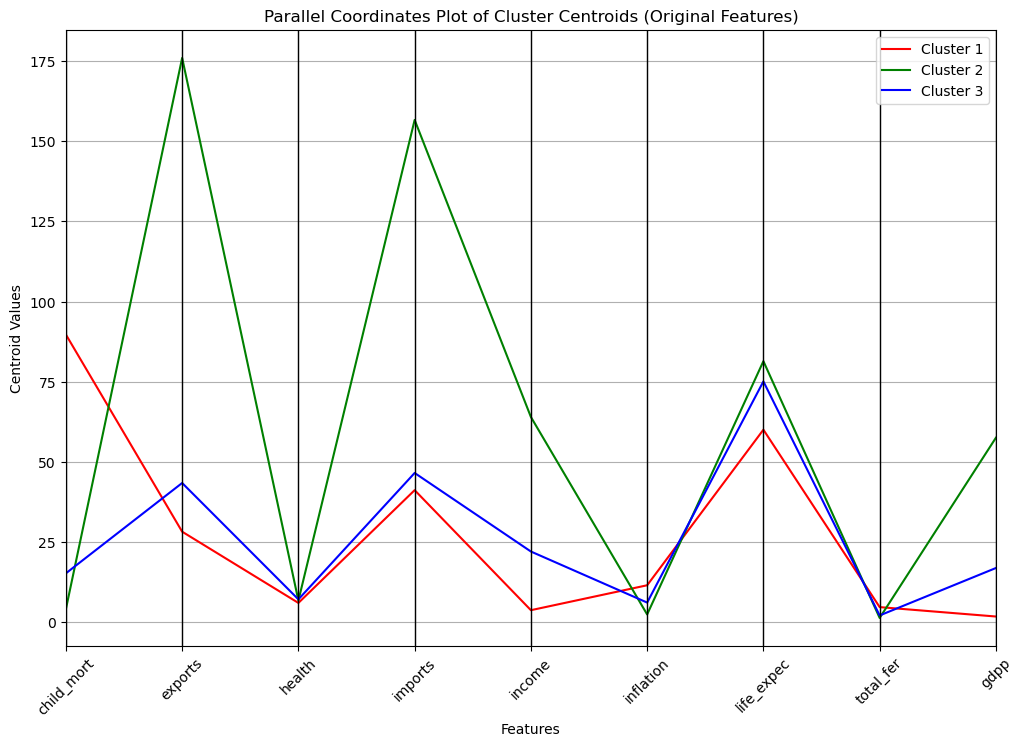

In [15]:
# Use the original data for K-Means clustering
original_data = countries_df.drop(columns=['country'])

# Define original features (all columns except 'country')
original_features = original_data.columns

# Re-run K-Means with the original data (no PCA)
kmeans_original = KMeans(n_clusters=3, random_state=42)
kmeans_original.fit(original_data)
centroids_original = kmeans_original.cluster_centers_

# Create a DataFrame with the original feature centroids
centroids_df = pd.DataFrame(centroids_original, columns=original_features)
centroids_df['Cluster'] = ['Cluster 1', 'Cluster 2', 'Cluster 3']

# Plot the parallel coordinates
plt.figure(figsize=(12, 8))
parallel_coordinates(centroids_df, class_column='Cluster', color=['r', 'g', 'b'])
plt.title('Parallel Coordinates Plot of Cluster Centroids (Original Features)')
plt.xlabel('Features')
plt.ylabel('Centroid Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Using this, we can see that life expectancy does indeed form a center point for our clusters to group around but there is also strong grouping for cluster 2 around exports as well as a big suprise with imports playing a large role in a cluster. 

GDPP, child mortality, and income being much less impactful to the groupings being formed than originally anticipated.

#### Discussion

From this we can now use the findings to make sure that HELP can better understand that many countries that share similarities in life expectancy will likely share import and export characteristics as well .

Using unsupervised learning in this regard has given us the tool to first, have visual representation of the features we can us so that organizations such as HELP can identify countries that might benefit most from shared policy in regards to disaster relief.

Such a feature would be the similarity in how import/exports number would relate to life expectancy. With this, they might be better able to adjust policies impacting life expectancy by looking at the import/export numbers.

#### Ways to improve

For future improvements, I would like to see if the Elbow Method would ahve also reached the same conclusion in regards to the best parameters as opposed to using the GridSearchCV.

Another point of interest would be to use geographic/geologic features to get a better understanding of the similarities between the countries that are being grouped together. The method used completely avoids using these and indeed, we even shyed away from using the country names when possible. Though, I'm certain some bias might be introduced at that point.|